In [1]:
import os
import sys
sys.path.append('/home/ilobach/ursse')
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')

In [2]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [3]:
df

revolution    delay
51                 51  62977.0
172               171  64337.0
241               239  62389.0
601               598  63454.0
1004              999  64303.0
...               ...      ...
452639788   450123392  63592.0
452640074   450123677  62846.0
452640278   450123880  62373.0
452640330   450123931  62842.0
452640764   450124364  62746.0

[1490076 rows x 2 columns]

In [4]:
gate = (61000, 67000)

In [5]:
n = 500
i = 200

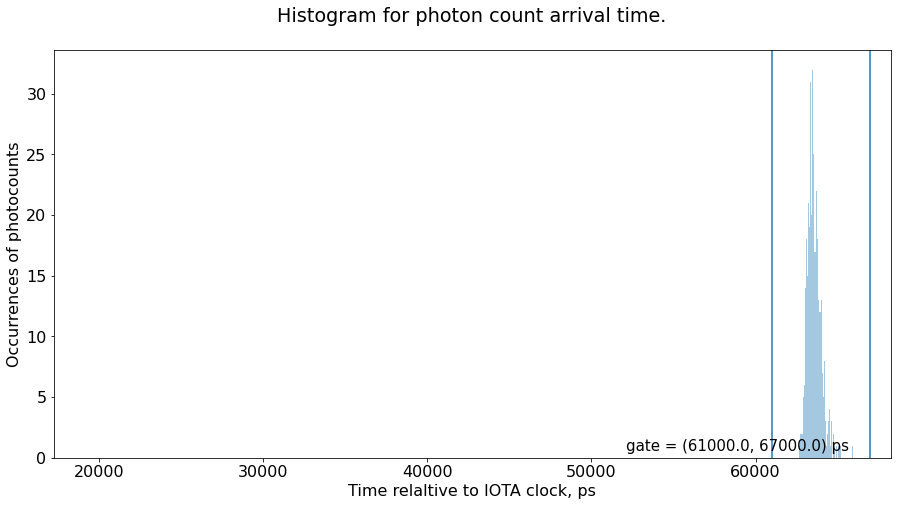

In [6]:
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [7]:
n_revolutions*133e-9

59.866547461

In [8]:
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec

In [9]:
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz,\
    reduce_df_to_one_gate, divide_df_into_time_bins, get_properties_in_time_bins

In [10]:
four_gates = get_bucket_gates(gate)
four_gates

[(61000.0, 67000.0),
 (94250.0, 100250.0),
 (127500.00000000001, 499.9999999999709),
 (27750.0, 33750.0)]

In [11]:
get_rate_in_gate_Hz(df, n_revolutions, gate)

24779.932414950392

In [12]:
df0 = reduce_df_to_one_gate(df, gate)
dt=0.0025
df0 = divide_df_into_time_bins(df0, dt)
df0

/home/ilobach/ursse/ursse/time_structure.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index_of_dt_bin'] = (df.revolution/revolutions_per_dt).astype(int)
/home/ilobach/ursse/ursse/time_structure.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_time'] = dt*df['index_of_dt_bin']
/home/ilobach/ursse/ursse/time_structure.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

revolution    delay  index_of_dt_bin  bin_time   time_sec
51                 51  62977.0                0    0.0000   0.000007
172               171  64337.0                0    0.0000   0.000023
241               239  62389.0                0    0.0000   0.000032
601               598  63454.0                0    0.0000   0.000080
1004              999  64303.0                0    0.0000   0.000133
...               ...      ...              ...       ...        ...
452626790   450110453  64424.0            23945   59.8625  59.864690
452627212   450110874  64363.0            23945   59.8625  59.864746
452627855   450111514  63701.0            23945   59.8625  59.864831
452628051   450111707  63311.0            23945   59.8625  59.864857
452628363   450112017  62304.0            23945   59.8625  59.864898

[1483455 rows x 5 columns]

In [13]:
time_bins_df = get_properties_in_time_bins(df0)
time_bins_df

time_sec  count         std
index_of_dt_bin                             
0                  0.0000     72  892.853336
1                  0.0025     66  836.632891
2                  0.0050     60  988.978388
3                  0.0075     64  746.272428
4                  0.0100     62  795.212597
...                   ...    ...         ...
23941             59.8525     59  910.639628
23942             59.8550     73  951.837001
23943             59.8575     65  999.665769
23944             59.8600     60  795.357682
23945             59.8625     56  850.007929

[23946 rows x 3 columns]

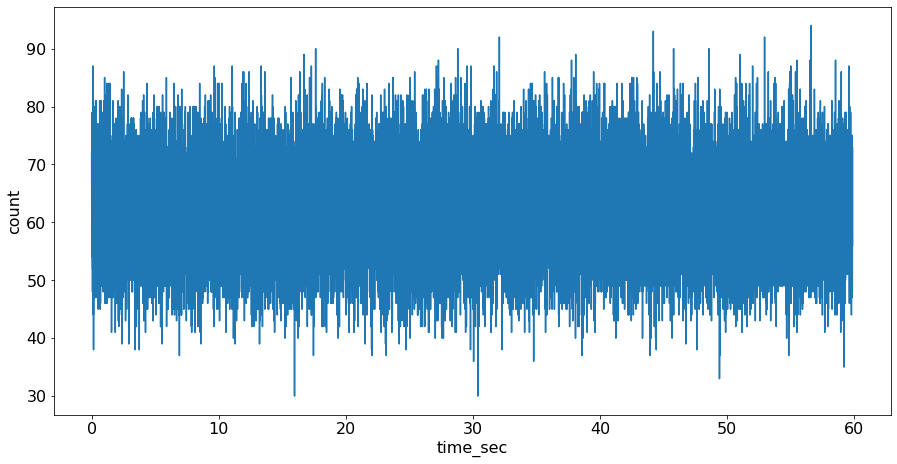

In [14]:
sns.lineplot(data=time_bins_df, x='time_sec', y='count')

In [23]:
import plotly.express as px
fig = px.scatter(x=time_bins_df['time_sec'], y=time_bins_df['std']**2)
fig.data[0].update(mode='markers+lines')
fig.show()

In [16]:
import plotly.express as px
fig = px.scatter(x=time_bins_df['time_sec'], y=time_bins_df['std']**2)
fig.data[0].update(mode='markers+lines')
fig.show()

In [17]:
time_bins_df['var'] = time_bins_df['std']**2

In [18]:
var = time_bins_df['var'].values
var_centers = (var[1:]+var[:-1])/2
var_diff = np.diff(var)/dt

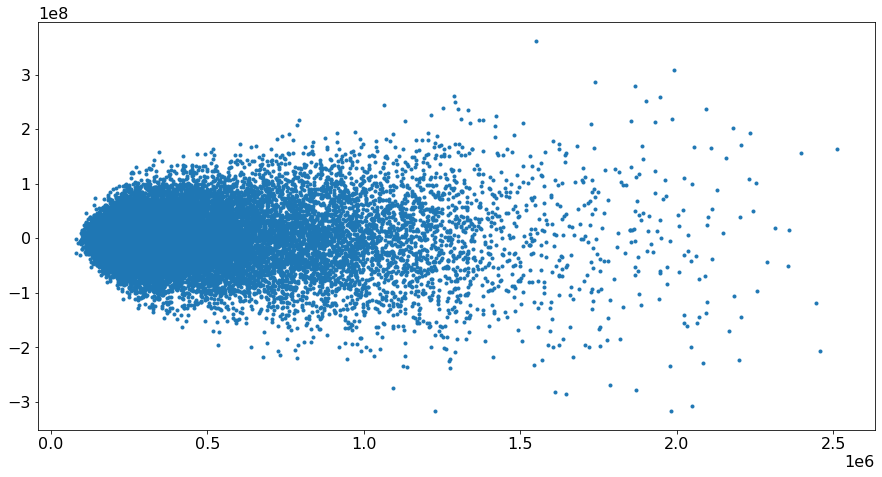

In [19]:
plt.plot(var_centers, var_diff, '.')

In [20]:
slope, intercept = np.linalg.lstsq(np.column_stack((var_centers, np.ones(var_centers.shape))), var_diff, rcond=None)[0]

In [21]:
-slope/2

0.002029995069652727

In [22]:
intercept/2/350**2

0.002367049797216649